In [1]:
from math import tau

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.linalg as LA
import scipy.signal as ss

from utils import *

plt.style.use('seaborn-notebook')
np.random.seed(293710966)

# Generazione del Segnale

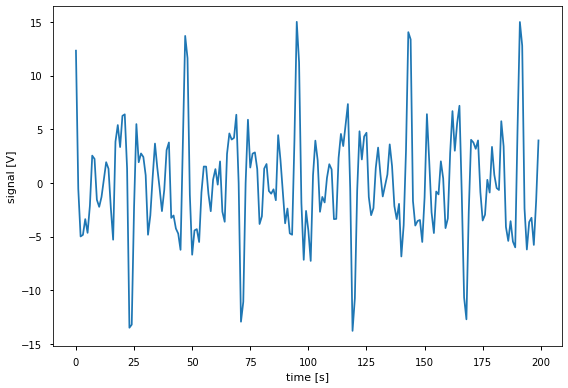

In [2]:
magnitudes = pd.read_csv('./harmonic-voltage-magnitude.csv', index_col='number')['typical']
phases = np.radians(pd.read_csv('./phases.csv', index_col='number'))['3.9']

power_freq = 50
sampling_freq = 2400
harmonic_numbers = np.arange(2, 14)
no_of_harmonics = harmonic_numbers.max() * 2

time = np.arange(4096.)

noise = np.random.normal(0, 1, time.size)
signal = noise.copy()

for n in harmonic_numbers:
    amp = magnitudes[n]
    phase = phases[n]
    omega = tau * n * power_freq / sampling_freq
    signal += amp * np.cos(omega * time + phase)

fig, ax = plt.subplots()
ax.plot(time[:200], signal[:200])
ax.set_xlabel('time [s]')
ax.set_ylabel('signal [V]')
fig.tight_layout()

In [ ]:
fastest_period = np.around(sampling_freq / power_freq).astype(int)
time_window = fastest_period * no_of_harmonics
data_size = signal.size - time_window + 1

windows = [signal[i : i + time_window] for i in range(data_size)]
data_matrix = np.vstack(windows)

print(f'numero di finestre: {data_matrix.shape[0]}')
print(f'larghezza finestre: {data_matrix.shape[1]}')

In [ ]:
correlation = data_matrix.conj().T @ data_matrix / data_matrix.shape[0]
correlation.shape

In [ ]:
# signal: K largest      -> M - K : M - 1
# noise: M - K smallest  -> 0 : M - K - 1

signal_pca = LA.eigh(correlation, subset_by_index=(time_window - no_of_harmonics, time_window - 1))
noise_pca = LA.eigh(correlation, subset_by_index=(0, time_window - no_of_harmonics - 1))
signal_eigvecs = signal_pca[1].T
noise_eigvecs = noise_pca[1].T

In [ ]:
omegas = np.linspace(0, np.pi, 2000)
freqs = omegas * sampling_freq / tau

steering_matrix = np.exp(1j * np.outer(omegas, np.arange(time_window)))
pseudo_power = 1 / np.sum(np.abs(noise_eigvecs @ steering_matrix.conj().T) ** 2, axis=0)

fig, ax = plt.subplots()
plotdb(ax, freqs, pseudo_power)
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Pseudospectrum [dB]')
fig.tight_layout()

In [ ]:
peaks_idx, _ = ss.find_peaks(pseudo_power)

peaks = pd.DataFrame()
peaks['omega'] = omegas[peaks_idx]
peaks['freq'] = freqs[peaks_idx]
peaks['power'] = pseudo_power[peaks_idx]
peaks = peaks.sort_values('power').tail(harmonic_numbers.size).sort_values('omega')

est_freqs = peaks.freq.values
est_omegas = peaks.omega.values
real_freqs = power_freq * harmonic_numbers
err_freqs = (est_freqs - real_freqs) / real_freqs

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

plotdb(ax1, freqs, pseudo_power)
plotdb(ax1, est_freqs, peaks.power, 'o')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_ylabel('Pseudospectrum [dB]')

ax2.plot(harmonic_numbers, err_freqs * 100, 'o-')
ax2.set_ylabel('Error on Frequency [%]')
ax2.set_xlabel('Harmonic Number')
ax2.xaxis.set_major_locator(plt.FixedLocator(harmonic_numbers))

fig.tight_layout()

In [ ]:
est_steering_matrix = np.exp(1j * np.outer(est_omegas, np.arange(time_window)))
est_noise_power = noise_pca[0].mean()

b = signal_pca[0][harmonic_numbers - 1] - est_noise_power
A = np.abs(signal_eigvecs[harmonic_numbers - 1] @ est_steering_matrix.conj().T) ** 2
est_powers = np.abs(LA.solve(A, b))

est_amplitudes = np.sqrt(2 * est_powers)
real_amplitudes = magnitudes[harmonic_numbers].values
err_amplitudes = (est_amplitudes - real_amplitudes) / real_amplitudes

fig, ax = plt.subplots()

ax.plot(harmonic_numbers, err_amplitudes * 100, 'o-')
ax.set_ylabel('Error on Amplitude [%]')
ax.set_xlabel('Harmonic Number')
ax.xaxis.set_major_locator(plt.FixedLocator(harmonic_numbers))

fig.tight_layout()